In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance, distance_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from threading import Thread

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Creation usefull instruments

In [2]:
class Color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

    
# function allows to print colorful and bold text
def pretty_print(text="", text_headers="", color="", bold=False):
    bold_part = Color.BOLD if bold else ""
    color_part = Color.__dict__.get(color.upper(), "")
    print(bold_part + color_part + text_headers + Color.END + text)


In [3]:
class Result:
    
    def __init__(self, model_name, model_parameters, model_score, data_for_graphics):
        self.__name = model_name
        self.__parameters = model_parameters
        self.__score = model_score
        if len(data_for_graphics) == 3:
            self.__X_test = data_for_graphics[0]
            self.__y_test = data_for_graphics[1]
            self.__y_hat = data_for_graphics[2]
        else:
            print("Model %s has no data for graphics", model_name)
            self.__X_test = None
            self.__y_test = None
            self.__y_hat = None
        
    def get_name(self):
        return self.__name
    
    def get_parameters(self):
        return self.__parameters
    
    def get_score(self):
        return self.__score

    def show_result_graphics(self):
        X_test = self.__X_test
        y_test = self.__y_test
        y_hat = self.__y_hat
        if  X_test is not None and y_test is not None and y_hat is not None:
            plt.subplot(1, 2, 1)
            plt.title("y_hat")
            plt.scatter(np.linspace(0, len(y_hat), len(y_hat)), y_hat, c='orange')
            plt.subplot(1, 2, 2)
            plt.title("y_test")
            plt.scatter(np.linspace(0, len(y_test), len(y_test)), y_test)
    
class Results:
    
    def __init__(self):
        self.__results = {}
        
    def create_id(self):
        new_key = 0
        keys = self.__results.keys()
        if keys:
            new_key = max(self.__results.keys()) + 1
        return new_key
    
    def add_result(self, model_name, model_parameters, model_score, data_for_graphics):
        self.__results.update({model_name: Result(model_name, model_parameters, model_score, data_for_graphics)})
        
    def get_results(self, show_model_parameters=False):
        results = {}
        for key, result_object in self.__results.items():
            model_info = {}
            if show_model_parameters:
                model_info["parameters"] = result_object.get_parameters()
            model_info["score"] = result_object.get_score()
            results.update({key: model_info})
        return results
    
    def get_concrete_result(self, model_name):
        return self.__results.get(model_name)

## Data loading from scv files
1. all_data - data of morning and afternoon datasets
2. morning_data - data of morning dataset
3. afternoon_data - data of afternoon dataset

In [4]:
separator = ','
all_data = pd.read_csv("all_data_preprocessed_filtering.csv", sep=separator)
morning_data = pd.read_csv("morning_data.csv", sep=separator)
afternoon_data =pd.read_csv("afternoon_data.csv", sep=separator)
datasets = [all_data, morning_data, afternoon_data]

In [5]:
all_data.head()

,age,gender,weight,smoking,diseasehypertonia,respiratory_disease,p_a,p_da,t_right_slopes,interval_pq,kurtosis,nn50,lfp,br
0,65,1,81,1,0,0,0.008323,0.000011,-0.000266,-0.149,1.183951,0,0.416088,31.292105
1,43,0,60,0,0,0,0.007437,0.000032,-0.000282,-0.054,0.573783,0,0.123064,36.408043
2,73,0,92,0,1,0,0.009876,0.000015,-0.000392,-0.091,0.321415,0,0.119404,19.919365
3,61,1,55,1,0,1,0.007188,0.000004,-0.000426,-0.079,0.205573,0,0.326354,20.744604
4,63,1,65,1,1,1,0.007358,-0.000011,-0.000370,-0.069,-0.389226,0,0.222550,17.599829


## Models

In [6]:
test_size = 0.3
data = deepcopy(all_data)
LGR_basic = [data, test_size, LogisticRegression(), "LogisticRegression_basic"]
DTC_basic = [data, test_size, DecisionTreeClassifier(), "DecisionTreeClassifier_basic"]
SVC_basic = [data, test_size, SVC(), "SVC_basic"]
KNC_basic = [data, test_size, KNeighborsClassifier(), "KNeighborsClassifier_basic"]
RFC_basic = [data, test_size, RandomForestClassifier(), "RandomForestClassifier_basic"]
LSVC_basic = [data, test_size, LinearSVC(), "LinearSVC_basic"]

results = Results()  # object for saving results
models = [LGR_basic, DTC_basic, SVC_basic, KNC_basic, RFC_basic, LSVC_basic]

In [7]:
def use_model(df, test_size, model_object, model_saving_name, parameters=None):
    def model_function(df, test_size, model_object, model_saving_name, parameters=None):
        data = deepcopy(df)
        y = data['respiratory_disease']
        X = data.drop(['respiratory_disease'], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)  # sharing dataset on train and test
        if not parameters:
            model_object.fit(X_train, y_train)
            y_hat = model_object.predict(X_test)
            model_score = accuracy_score(y_hat, y_test)
            data_for_graphics = [X_test, y_test, y_hat]
            results.add_result(model_saving_name, model_object.get_params(), model_score, data_for_graphics)
            
    model_thread = Thread(target=model_function, args=[df, test_size, model_object, model_saving_name, parameters])
    model_thread.start()

In [8]:
for model in models:
    use_model(*model)

In [9]:
results.get_results()

{'DecisionTreeClassifier_basic': {'score': 0.9044585987261147},
 'KNeighborsClassifier_basic': {'score': 0.9378980891719745},
 'LinearSVC_basic': {'score': 0.9140127388535032},
 'LogisticRegression_basic': {'score': 0.928343949044586},
 'RandomForestClassifier_basic': {'score': 0.928343949044586},
 'SVC_basic': {'score': 0.9378980891719745}}

### DecisionTreeClassifier_basic

Total score of model is: 0.9044585987261147


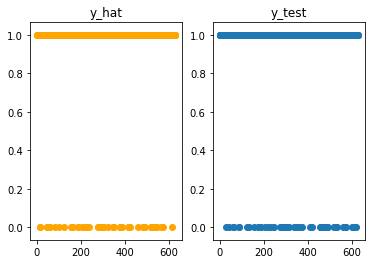

In [10]:
result_object = results.get_concrete_result('DecisionTreeClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### KNeighborsClassifier_basic

Total score of model is: 0.9378980891719745


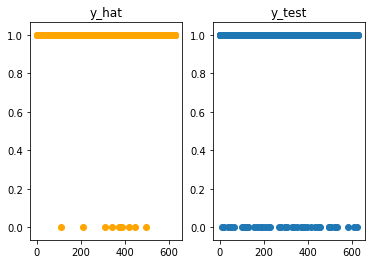

In [11]:
result_object = results.get_concrete_result('KNeighborsClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### LinearSVC_basic

Total score of model is: 0.9140127388535032


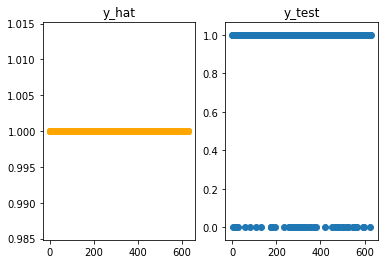

In [12]:
result_object = results.get_concrete_result('LinearSVC_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### LogisticRegression_basic

Total score of model is: 0.928343949044586


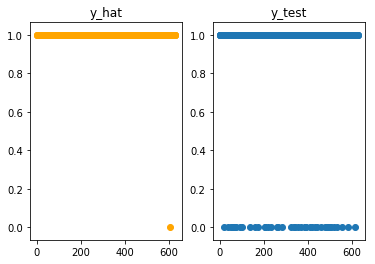

In [13]:
result_object = results.get_concrete_result('LogisticRegression_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### RandomForestClassifier_basic

Total score of model is: 0.928343949044586


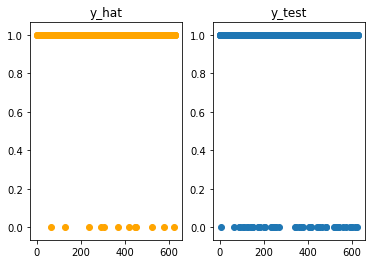

In [14]:
result_object = results.get_concrete_result('RandomForestClassifier_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### SVC_basic

Total score of model is: 0.9378980891719745


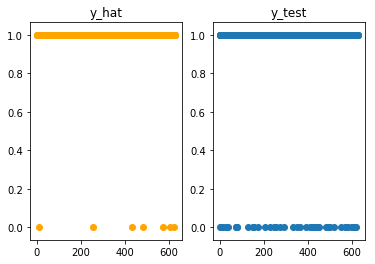

In [15]:
result_object = results.get_concrete_result('SVC_basic')
result_object.show_result_graphics()
print("Total score of model is:", result_object.get_score())

### Logistic Regression GSCV

In [13]:
data = deepcopy(all_data)
y = data['respiratory_disease']
X = data.drop(['respiratory_disease'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)  # sharing dataset on train and test



parameters = {'kernel':('rbf', 'sigmoid'), 'C':[1, 10]}
classifier = GridSearchCV(SVC(), parameters)
classifier.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ('rbf', 'sigmoid'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)